## Step 1: Setup & download images of ~~birds~~ labradoodles & non-birds

In [2]:
# Install dependencies 
!pip install -Uqq fastai==2.7.10
!pip install -Uqq duckduckgo_search

import fastai
fastai.__version__

'2.7.10'

In [4]:
# Import required libs from DDG (for web search)
# and fastai 
from duckduckgo_search import ddg_images 
from fastcore.all import *

# Helper method returns URL(s) of images searched on DDG 
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Test the search method 

In [5]:
urls = search_images('labradoodle photos', max_images=1)
urls[0]

Searching for 'labradoodle photos'


'https://pacificrimlabradoodles.com/wp-content/uploads/2020/03/Laverne-Louie-pup-Flynn-Grothe.jpeg'

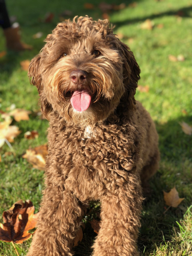

In [7]:
from fastdownload import download_url
dest = 'labradoodle.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

Now let's do similar with forest photos (eg not labradoodles)

Searching for 'forest photos'


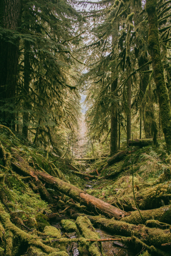

In [8]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=True)

Image.open('forest.jpg').to_thumb(256, 256)

In [10]:
searches = 'forest', 'labradoodle'
path = Path('labradoodle_or_not')

In [9]:
from time import sleep 

for o in searches: 
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'labradoodle photo'
Searching for 'labradoodle sun photo'
Searching for 'labradoodle shade photo'


## Step 2: Train our model 

Some photos may not have downloaded correctly, which can cause an error in model training. Fastai provides a `verify_images` method in it's vision utilities. 

https://docs.fast.ai/vision.utils.html

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model but not used during training). In `fastai` we can create that easily using `DataBlock`, and view sample images from it:

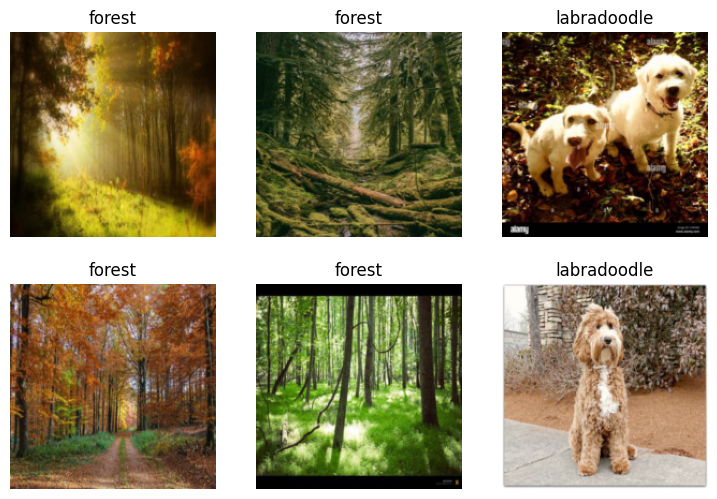

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Explanation of the `DataBlock` parameters above:

```python
blocks=(ImageBlock, CategoryBlock)
```
The inputs to our model are images, and the outputs are categories (in this case, "labradoodle" or "forest")

### Train the model

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/opt/homebrew/Caskroom/miniforge/base/envs/torchgpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torchgpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.846902,0.013227,0.000000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.044414,0.001331,0.000000,00:07
1,0.037397,0.000540,0.000000,00:07
2,0.031011,0.000267,0.000000,00:07
3,0.022414,0.000142,0.000000,00:07
4,0.019880,0.000042,0.000000,00:07


## Step 3: Use our model 

Use the model created in Step 2 to test the original labradoodle image we downloaded in Step 1.

### Troubleshooting note

The following error appears to occur if using FastAI v2.7.11:
```
File /opt/homebrew/Caskroom/miniforge/base/envs/torchgpu/lib/python3.8/site-packages/PIL/Image.py:517, in Image.__getattr__(self, name)
    515     deprecate("Image categories", 10, "is_animated", plural=True)
    516     return self._category
--> 517 raise AttributeError(name)

AttributeError: read
```

This is resolved by installing FastAI v2.7.10
https://forums.fast.ai/t/lesson-1-official-topic/95287/473



In [15]:
# Try a labradoodle image
test_image = PILImage.create('labradoodle.jpg')
is_labradoodle,_,probs = learn.predict(test_image)
print(f"This is a: {is_labradoodle}")
print(f"Probability it's a labradoodle: {probs[0]:.4f}")

# Try a forest image
test_image = PILImage.create('forest.jpg')
is_labradoodle,_,probs = learn.predict(test_image)
print(f"This is a: {is_labradoodle}")
print(f"Probability it's a labradoodle: {probs[0]:.4f}")

This is a: labradoodle
Probability it's a labradoodle: 0.0000


This is a: forest
Probability it's a labradoodle: 0.9999
